In [52]:
import torch
import importlib

Player Input

In [58]:
import Player_Prep
importlib.reload(Player_Prep)
from Player_Prep import Generate_Pitchers, Generate_Pitcher_Mutators, Generate_Test_Train

In [54]:
pitching_components = 5
park_components = 2
person_components = 3
init_components = 3

input_size = pitching_components + park_components + person_components + init_components

In [55]:
pitcher_input, pitcher_output, (pitching_stddev,
                                park_stddev,
                            person_stddev), pitcher_ids = Generate_Pitchers(pitching_components,
                        park_components,
                        person_components)

Player Mutators

In [56]:
pitching_scale = 0.2
person_scale = 0.3
draft_scale = 0.2
park_scale = 0.1
signing_age_scale = 0.5

batch_size = 800
max_input_size = 79

In [59]:
pitching_mutators = Generate_Pitcher_Mutators(batch_size, max_input_size,
                        pitching_components,pitching_scale,pitching_stddev,
                        park_components, park_scale, park_stddev,
                        person_components, person_scale, person_stddev,
                        draft_scale, signing_age_scale)

Test/Train Split

In [60]:
import Dataset
importlib.reload(Dataset)
from Dataset import PitcherDataset

In [61]:
test_size = 0.2
random_state = 1

x_train_padded, x_test_padded, y_train_padded, y_test_padded, train_lengths, test_lengths = Generate_Test_Train(
    pitcher_input, pitcher_output, test_size, random_state)

train_pitchers_dataset = PitcherDataset(x_train_padded, train_lengths, y_train_padded)
test_pitchers_dataset = PitcherDataset(x_test_padded, test_lengths, y_test_padded)

In [62]:
print(y_train_padded.shape)
print(pitcher_output[0].shape)

torch.Size([73, 10172, 3])
torch.Size([18, 3])


Train Model

In [63]:
import Model
import Constants
import Model_Train
from torch.optim import lr_scheduler

importlib.reload(Model)
importlib.reload(Constants)
importlib.reload(Model_Train)

from Model import RNN_Model, LSTM_Model, RNN_Classification_Loss
from Constants import device
from Model_Train import trainAndGraph

In [64]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Num. Parameters: 10521
Epoch [1/1000], Train Loss: 2.3796, Test Loss: 1.2110
Epoch [11/1000], Train Loss: 0.7752, Test Loss: 0.8438
Epoch [21/1000], Train Loss: 0.7149, Test Loss: 0.7798
Epoch [31/1000], Train Loss: 0.6499, Test Loss: 0.7133
Epoch [41/1000], Train Loss: 0.6372, Test Loss: 0.7141
Epoch [51/1000], Train Loss: 0.6366, Test Loss: 0.7158
Epoch [61/1000], Train Loss: 0.6275, Test Loss: 0.7077
Epoch [71/1000], Train Loss: 0.6085, Test Loss: 0.7008
Epoch [81/1000], Train Loss: 0.6074, Test Loss: 0.6859
Epoch [91/1000], Train Loss: 0.5980, Test Loss: 0.6853
Epoch [101/1000], Train Loss: 0.5891, Test Loss: 0.6920
Epoch [111/1000], Train Loss: 0.5928, Test Loss: 0.6847
Epoch [121/1000], Train Loss: 0.5854, Test Loss: 0.6795
Epoch [131/1000], Train Loss: 0.5828, Test Loss: 0.6808
Epoch [141/1000], Train Loss: 0.5792, Test Loss: 0.6851
Epoch [151/1000], Train Loss: 0.5874, Test Loss: 0.6755
Epoch [161/1000], Train Loss: 0.5798, Test Loss: 0.6739
Epoch [171/1000], Train Loss: 0.5756

0.6726088970899582

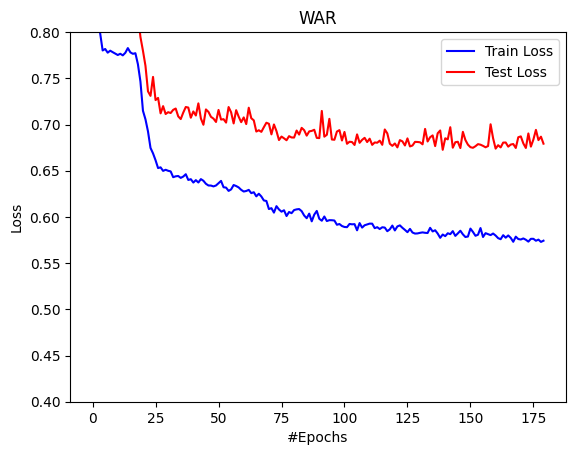

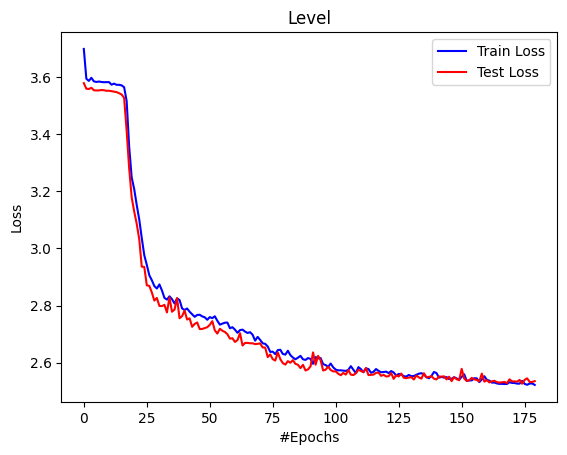

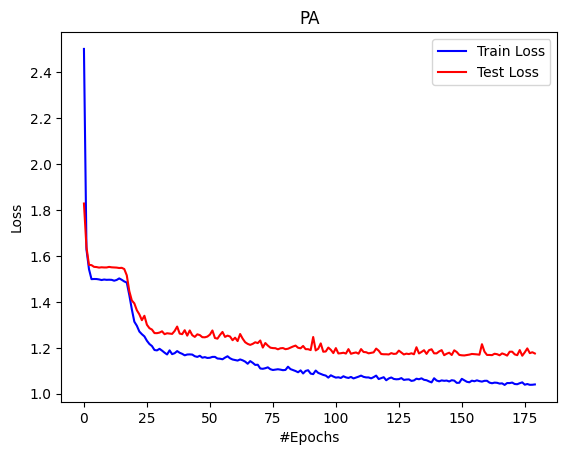

In [65]:
dropout_perc = 0.0
num_layers = 5
hidden_size = 15
network = RNN_Model(input_size, num_layers, hidden_size, dropout_perc, pitching_mutators)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.003)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, cooldown=5, verbose=False)
loss_function = RNN_Classification_Loss

num_epochs = 1000
training_generator = torch.utils.data.DataLoader(train_pitchers_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_pitchers_dataset, batch_size=batch_size, shuffle=False)

graph_y_range=(0.4,1.0)
trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, 10, early_stopping_cutoff=40, should_output=True, graph_y_range=graph_y_range)

Sanity Check

Check what model things of certain players

In [66]:
import torch.nn.functional as F
importlib.reload(Dataset)
from Dataset import WAR_BUCKETS, LEVEL_BUCKETS, BF_BUCKETS

In [67]:
paddedHitterInput = torch.nn.utils.rnn.pad_sequence(pitcher_input)
hitterLengths = torch.tensor([len(seq) for seq in pitcher_input])
network.load_state_dict(torch.load("best_model.pt"))
network.eval()
network = network.to(device)

def GetPlayer(name, id, stat):
    with torch.no_grad():
        for i, hitter in enumerate(pitcher_ids):
            if hitter == id:
                idx = i
                break
            
        input = paddedHitterInput[:,idx,:].unsqueeze(0).clone()
        # input[:,:,1] = (input[0,0,1] - pickMean) / pickStd
        output_war, output_level, output_pa = network(input.to(device), hitterLengths[idx].unsqueeze(0).to(device))

        print(name)
        torch.set_printoptions(precision=2, sci_mode=False, linewidth=1000)
        
        if stat == "WAR":
            print("WAR")
            print(F.softmax(output_war.squeeze(0).squeeze(1).data, dim=1).cpu())
            print(pitcher_output[idx][0][0].item())
            print(torch.bucketize(pitcher_output[idx][0][0], WAR_BUCKETS).cpu().item())
        elif stat == "Level":
            print("Level")
            print(F.softmax(output_level.squeeze(0).squeeze(1).data, dim=1).cpu())
            print(pitcher_output[idx][0][1].item())
            print(torch.bucketize(pitcher_output[idx][0][1], LEVEL_BUCKETS).cpu().item())
        
        elif stat == "PA":
            print("PA")
            print(F.softmax(output_pa.squeeze(0).squeeze(1).data, dim=1).cpu())
            print(pitcher_output[idx][0][2].item())
            print(torch.bucketize(pitcher_output[idx][0][2], BF_BUCKETS).cpu().item())

In [69]:
stat = "WAR"
GetPlayer("Ben Tootle", 572211, stat)
GetPlayer("Aaron Nola", 605400, stat)
GetPlayer("Kyle Gibson", 502043, stat)

Ben Tootle
WAR
tensor([[    0.83,     0.07,     0.06,     0.03,     0.01,     0.00,     0.00],
        [    0.84,     0.08,     0.05,     0.02,     0.01,     0.00,     0.00],
        [    0.90,     0.06,     0.03,     0.01,     0.00,     0.00,     0.00],
        [    0.88,     0.07,     0.04,     0.01,     0.00,     0.00,     0.00],
        [    0.93,     0.04,     0.02,     0.00,     0.00,     0.00,     0.00],
        [    0.94,     0.04,     0.02,     0.00,     0.00,     0.00,     0.00],
        [    0.94,     0.04,     0.02,     0.00,     0.00,     0.00,     0.00],
        [    0.95,     0.03,     0.02,     0.00,     0.00,     0.00,     0.00],
        [    0.96,     0.02,     0.01,     0.00,     0.00,     0.00,     0.00],
        [    0.98,     0.01,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.01,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.99,     0.01,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    1.00,     0.

Save Model Results for Players

In [16]:
import Output
importlib.reload(Constants)
importlib.reload(Player_Prep)
importlib.reload(Output)
from Output import Delete_Model_Run_Pitcher, Generate_Model_Run_Pitcher
from Constants import db

In [17]:
cursor = db.cursor()
all_pitcher_ids = cursor.execute("SELECT mlbId FROM Model_Players WHERE isPitcher='1'").fetchall()

In [18]:
# model = "test_run_hitters"
# Delete_Model_Run_Hitter(model)
# Generate_Model_Run_Hitter(model, all_hitter_ids, hitter_ids, network, device, leave_progress=True)